In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
%matplotlib inline

https://www.zillow.com/homedetails/8033-Corliss-Ave-N-Seattle-WA-98103/48795791_zpid/

In [208]:
data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
data.drop(columns='Unnamed: 0', inplace=True)

In [209]:
X = data.drop(columns=['price','date', 'id', 'long', 'lat'])
y = data['price']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [211]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

11584 5706 11584 5706


In [212]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Baseline Model

In [213]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [214]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [215]:
model.score(X_train, y_train)

0.6591415652326508

In [10]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 47828488890.15646
Test Mean Squarred Error: 49323179158.84091


In [11]:
X_train.shape, y_train.shape

((11584, 16), (11584,))

In [12]:
y_train

81       392000.0
10676    386000.0
532      985000.0
958      950000.0
472      397500.0
           ...   
11284    469000.0
11964    450000.0
5390     295000.0
860      459000.0
15795    285000.0
Name: price, Length: 11584, dtype: float64

In [13]:
mse = mean_squared_error(y_train, model.predict(X_train))
rmse = mse**.5
rmse

218697.25396116995

In [14]:
X_train.iloc[81:82]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
15054,2,1.75,1550,6000,1.0,0,1,3,7,1550,0,1920,0,98199,2360,6000


In [15]:
model.predict(X_train)

array([ 385883.45164348,  671503.19745647, 1258252.70993052, ...,
        338833.59632827,  509544.46411364,  408057.50510748])

# Select KBest for Feature Selection (not the best way)

In [16]:
select_feature = SelectKBest(chi2, k=8).fit(X_train, y_train)

selected_features_df = pd.DataFrame({'Feature': list(X_train.columns),
                                    'Scores': select_feature.scores_})

selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
3,sqft_lot,2.667166e+08
15,sqft_lot15,1.205941e+08
12,yr_renovated,6.017861e+06
2,sqft_living,3.126866e+06
10,sqft_basement,2.818109e+06
9,sqft_above,2.568302e+06
14,sqft_living15,1.628034e+06
6,view,1.216335e+04
5,waterfront,5.375330e+03
1,bathrooms,1.596854e+03


In [17]:
x_train_chi = select_feature.transform(X_train)
x_test_chi = select_feature.transform(X_test)

In [18]:
lr_chi_model = model.fit(x_train_chi, y_train)

In [19]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 47828488890.15646
Test Mean Squarred Error: 49323179158.84091


In [20]:
mse = mean_squared_error(y_train, model.predict(x_train_chi))
rmse = mse**.5
rmse

249594.90510552606

In [21]:
lr_chi_model.score(x_train_chi, y_train)

0.5560246916559797

# Recursive Feature Selection

In [22]:
rfe = RFE(estimator=model, n_features_to_select=7, step=1)
rfe = rfe.fit(X_train, y_train)

In [23]:
selected_rfe_features= pd.DataFrame({'Feature': list(X_train.columns),
                                    'Ranking': rfe.ranking_})

selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,bathrooms,1
4,floors,1
5,waterfront,1
6,view,1
7,condition,1
8,grade,1
11,yr_built,1
0,bedrooms,2
2,sqft_living,3
10,sqft_basement,4


In [24]:
x_train_rfe = rfe.transform(X_train)
x_test_rfe = rfe.transform(X_test)

In [25]:
x_train_rfe[:3]

array([[2.250e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 7.000e+00,
        1.974e+03],
       [2.250e+00, 2.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 8.000e+00,
        1.965e+03],
       [3.250e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.100e+01,
        1.988e+03]])

In [26]:
lr_rfe_model = model.fit(x_train_rfe, y_train)

In [27]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 47828488890.15646
Test Mean Squarred Error: 49323179158.84091


In [28]:
mse = mean_squared_error(y_train, model.predict(x_train_rfe))
rmse = mse**.5
rmse

232909.24301486567

In [29]:
lr_rfe_model.score(x_train_rfe, y_train)

0.6134009047861184

# Baseline with only useful features

In [30]:
X = data.drop(columns=['price','date', 'id', 'long', 'lat', 'sqft_basement', 'sqft_above', 'zipcode', 'sqft_living15', 'yr_renovated', 'sqft_lot15', 'sqft_lot'])
y = data['price']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
refinedmodel = LinearRegression()
refinedmodel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
y_hat_train = refinedmodel.predict(X_train)
y_hat_test = refinedmodel.predict(X_test)

In [34]:
refinedmodel.score(X_train, y_train)

0.6575701215830925

In [35]:
mse = mean_squared_error(y_train, refinedmodel.predict(X_train))
rmse = mse**.5
rmse

219200.79910550115

In [36]:
a = refinedmodel.predict(X_test)

In [37]:
a[:10]

array([ 298699.88218016,  982909.80860408,  371187.14162554,
       1086773.15510369,  199348.13408831,  514903.55865369,
        196223.45741668,  677212.81993635,  287734.0637323 ,
        345126.75374157])

In [38]:
y_test.head(10)

2950      300000.0
16390     850000.0
4999      332500.0
1599     1650000.0
9575      224097.0
10062     338000.0
3189      259950.0
8639     1112000.0
3745      222000.0
13876     500000.0
Name: price, dtype: float64

# SGD Regressor

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [40]:
SGDClf = linear_model.SGDRegressor(max_iter = 400, tol=1e-3,penalty = "L1")
SGDClf.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=400,
             n_iter_no_change=5, penalty='L1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [41]:
ypred = SGDClf.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  8.835680638249354e+30
RMSE:  4.417840319124677e+30


In [42]:
X_train

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built
81,3,2.25,1790,1.0,0,0,3,7,1974
10676,4,2.25,2050,2.0,0,2,3,8,1965
532,4,3.25,4030,2.0,0,0,3,11,1988
958,5,3.00,4530,1.5,0,0,4,9,2003
472,4,2.50,2570,2.0,0,0,3,8,1992
...,...,...,...,...,...,...,...,...,...
11284,4,2.50,2240,1.0,0,0,3,7,1961
11964,5,2.75,2710,2.0,0,0,3,8,2014
5390,4,2.00,1650,1.0,0,0,3,7,1964
860,4,3.00,1900,2.0,0,0,3,7,1954


In [43]:
y_train

81       392000.0
10676    386000.0
532      985000.0
958      950000.0
472      397500.0
           ...   
11284    469000.0
11964    450000.0
5390     295000.0
860      459000.0
15795    285000.0
Name: price, Length: 11584, dtype: float64

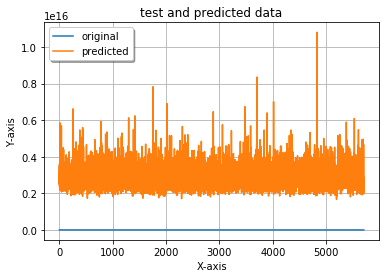

In [44]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

 

In [45]:
xnew = [[4 ,2.25 ,2050 ,9583 ,2.0 ,0 ,2 ,3 ,8 ,1770 ,280 ,1965 ,0 ,98198 ,2230 ,9730]]

In [48]:
y_new = SGDClf.predict(xnew)

ValueError: shapes (1,16) and (9,) not aligned: 16 (dim 1) != 9 (dim 0)

 # Huber Regression

In [158]:
data['floors'] = data['floors'].astype(np.int64)

In [159]:
# evaluate a model
def evaluate_model(X, y, model):
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    return abs(scores)

In [143]:
# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
    print(X.shape, y.shape)
    # fut the model on all data
    model.fit(X, y)
    # plot the dataset
    plt.scatter(X['floors'], y)
    # plot the line of best fit
    xaxis = np.arange(X.iloc[:,0].min(), X.iloc[:,0].max(), 0.01)
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
    plt.plot(xaxis, yaxis, color='r')
    # show the plot
    plt.title(type(model).__name__)
    plt.show()
 

In [160]:
# define the model
model = HuberRegressor()
# evaluate model
results = evaluate_model(X_train, y_train, model)
print('Mean MAE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
# plot the line of best fit
#plot_best_fit(X_train, y_train, model)

Mean MAE: 162288.741 (5640.670)


In [162]:
model.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [152]:
y_new = model.predict(X_train)
y_new

array([474500.39374223, 523025.567029  , 990071.86551932, ...,
       366956.95320063, 568684.27525111, 593951.19736864])

In [163]:
mse = mean_squared_error(y_train, model.predict(X_train))
rmse = mse**.5
rmse

271900.6354472465

# RANSAC Regressor

In [165]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor()
# evaluate model
results = evaluate_model(X_train, y_train, model)

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
rmse = mse**.5
rmse


335675.3689407804

# TheilSenRegressor

In [167]:
from sklearn.linear_model import TheilSenRegressor

model = TheilSenRegressor()
# evaluate model
results = evaluate_model(X, y, model)
model.fit(X_train, y_train)
y_new = model.predict(X_train)
mse = mean_squared_error(y_train, y_new)
rmse = mse**.5
rmse

249276.0117201144

In [184]:
from sklearn.metrics import r2_score